In [1]:
import pandas as pd
import openpyxl
import os
import tslearn

file_path = os.path.join("..", "data", "Final Transactions With Flags.csv")
data_in = pd.read_csv(file_path, low_memory=False)

In [2]:
data_in.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'No. of Litres',
       'Transaction Amount', 'VEHICLE MAKE', 'MODEL DERIVATIVE', 'DEPARTMENT',
       'RATE CARD CATEGORY', 'Site', 'District', 'Site Lat', 'Site Long',
       'Merchant Lat', 'Merchant Long', 'Fuel Type',
       'Estimated Price Per Litre', 'Coastal Petrol', 'Inland Petrol',
       'Coastal Diesel', 'Inland Diesel', 'Month Name', 'Weekday Name',
       'Average_Category_Amount', 'Transaction_Amount_Flag',
       'Days_Between_Transactions', 'Transaction_Frequency_Flag',
       'Coastal Diesel Adjusted', 'Price Difference', 'Fuel_Price_Flag',
       'Number_of_Flags'],
      dtype='object')

In [4]:
# Display the value counts for the number of flags
data_in['Number_of_Flags'].value_counts()

Number_of_Flags
0    140110
1     33707
2      2103
3        13
Name: count, dtype: int64

In [5]:
# Change all the Number of Flags that are currently 3 to 2 since there are so few of them
data_in['Number_of_Flags'] = data_in['Number_of_Flags'].replace(3, 2)

In [6]:
data_in['Number_of_Flags'].value_counts()

Number_of_Flags
0    140110
1     33707
2      2116
Name: count, dtype: int64

In [7]:
data_in['Fuel Price'] = data_in.apply(lambda row: row['Coastal Diesel'] if row['Fuel Type'] == 'Diesel' else row['Coastal Petrol'], axis=1)

In [8]:
# Check the value counts for the districts
data_in['District'].value_counts()

District
Unknown                 73727
Sarah Baartman          17638
OR Tambo                16930
Chris Hani              13594
Amathole                12727
Joe Gqabi               12241
Alfred Nzo              11485
Buffalo City             8820
Nelson Mandela           4602
Nelson Mandela Metro     2505
Head Office              1291
EMS College               373
Name: count, dtype: int64

In [9]:
# Get the names of the districts with less than 10 000 transactions
districts = data_in['District'].value_counts()
districts = districts[districts < 10000]

# Replace the names of the districts with less than 10 000 transactions with 'Other'
data_in['District_new'] = data_in['District'].replace(districts.index, 'Other')

In [10]:
# Check the value counts for the districts
data_in['District_new'].value_counts()

District_new
Unknown           73727
Sarah Baartman    17638
Other             17591
OR Tambo          16930
Chris Hani        13594
Amathole          12727
Joe Gqabi         12241
Alfred Nzo        11485
Name: count, dtype: int64

In [11]:
# Check the value counts for the vehicle make
data_in['VEHICLE MAKE'].value_counts()

VEHICLE MAKE
VOLKSWAGEN       55516
TOYOTA           37971
ISUZU            36418
NISSAN           22699
FORD             16061
HYUNDAI           3267
Nissan             977
AUDI               531
OPEL               511
MERCEDES-BENZ      495
Ford               404
BMW                383
CHEVROLET          341
LANDROVER          221
JEEP                78
TATA                35
MAHINDRA            15
FIAT                10
Name: count, dtype: int64

In [12]:
# Get the names of the makes with less than 10 000 transactions
makes = data_in['VEHICLE MAKE'].value_counts()
makes = makes[makes < 10000]

# Replace the names of the makes with less than 10 000 transactions with 'Other'
data_in['Make_new'] = data_in['VEHICLE MAKE'].replace(makes.index, 'Other')

In [13]:
# Check the value counts for the vehicle make
data_in['Make_new'].value_counts()

Make_new
VOLKSWAGEN    55516
TOYOTA        37971
ISUZU         36418
NISSAN        22699
FORD          16061
Other          7268
Name: count, dtype: int64

In [14]:
# Check the value counts for the vehicle categories
data_in['RATE CARD CATEGORY'].value_counts()

RATE CARD CATEGORY
 1: Sedan 1400-1600cc                     32324
 8: LDV Ambulance                         22245
 18: Ambulances Large p/van               20727
MANAGED MAINTENANCE                       20482
 6: LDV 4x2 D/Cab                         17487
 5: LDV 4x2 1 ton                         14569
 33: LDV D/cab Response                    9227
 2: Sedan Traffic 1400-1600cc              7757
 29: Bus 20-23 seater                      6207
 46: 14-16 Seater Patient Transport        4081
 15: Minibus 14-16 seater                  3756
 7: LDV Mortuary                           3471
 13: LDV 4x4 D/Cab                         3015
 9: LDV Clinic                             2759
 11: LDV 4x4 1 ton light                   2337
 10: LDV Rescue                            1621
 17: Ambulances  standard p/van            1132
 34: LDV Traffic                            917
 38: LDV Mortuary-Hydraulic                 736
 12: LDV 4x4 1 ton heavy                    326
 32: LDV Heavy Rescue

In [15]:
# Get the names of the categories with less than 5 000 transactions
cat = data_in['RATE CARD CATEGORY'].value_counts()
cat = cat[cat < 5000]

# Replace the names of the makes with less than 5 000 transactions with 'Other'
data_in['Cat_new'] = data_in['RATE CARD CATEGORY'].replace(cat.index, 'Other')

In [16]:
# Set the "MANAGED MAINTENANCE" value in Cat_new to "Other" - not indicative of true category
data_in['Cat_new'] = data_in['Cat_new'].replace('MANAGED MAINTENANCE', 'Other')

# Trim the Cat_new column to remove leading and trailing spaces
data_in['Cat_new'] = data_in['Cat_new'].str.strip()

# Check the value counts for the vehicle categories
data_in['Cat_new'].value_counts()

Cat_new
Other                           45390
1: Sedan 1400-1600cc            32324
8: LDV Ambulance                22245
18: Ambulances Large p/van      20727
6: LDV 4x2 D/Cab                17487
5: LDV 4x2 1 ton                14569
33: LDV D/cab Response           9227
2: Sedan Traffic 1400-1600cc     7757
29: Bus 20-23 seater             6207
Name: count, dtype: int64

In [18]:
data_in.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'No. of Litres',
       'Transaction Amount', 'VEHICLE MAKE', 'MODEL DERIVATIVE', 'DEPARTMENT',
       'RATE CARD CATEGORY', 'Site', 'District', 'Site Lat', 'Site Long',
       'Merchant Lat', 'Merchant Long', 'Fuel Type',
       'Estimated Price Per Litre', 'Coastal Petrol', 'Inland Petrol',
       'Coastal Diesel', 'Inland Diesel', 'Month Name', 'Weekday Name',
       'Average_Category_Amount', 'Transaction_Amount_Flag',
       'Days_Between_Transactions', 'Transaction_Frequency_Flag',
       'Coastal Diesel Adjusted', 'Price Difference', 'Fuel_Price_Flag',
       'Number_of_Flags', 'Fuel Price', 'District_new', 'Make_new', 'Cat_new'],
      dtype='object')

# Create the train and test sets

In [17]:
# Select the columns from the data that we want to use
data = data_in[['Transaction Amount', 'No. of Litres', 'District_new', 'Make_new', 'Fuel Type', 'Fuel Price', 'Number_of_Flags', 'Cat_new']]

# Create a small random subset of the data to use for testing - comment out later
# data = data.sample(n=30000, random_state=1)

In [18]:
data.head()

,Transaction Amount,No. of Litres,District_new,Make_new,Fuel Type,Fuel Price,Number_of_Flags,Cat_new
0,713.00,44.89,OR Tambo,FORD,Diesel,13.5212,0,8: LDV Ambulance
1,1029.14,63.80,OR Tambo,FORD,Diesel,13.5212,0,8: LDV Ambulance
2,901.66,53.90,OR Tambo,FORD,Diesel,14.1612,1,8: LDV Ambulance
3,781.50,48.12,OR Tambo,FORD,Diesel,14.1612,0,8: LDV Ambulance
4,884.56,54.46,OR Tambo,FORD,Diesel,14.1612,0,8: LDV Ambulance


# Linear Support Vector Machine

In [21]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif

# 2. Data Preprocessing
# Define categorical and numerical features
categorical_features = ['District_new', 'Make_new', 'Fuel Type', 'Cat_new']
numerical_features = ['Transaction Amount', 'No. of Litres', 'Fuel Price']

# Split data into features and target variable
X = data.drop(['Number_of_Flags'], axis=1)
y = data['Number_of_Flags']

In [24]:
# Split data into training and testing sets using stratified sampling
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
train_index, test_index = next(splitter.split(X, y))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [ ]:

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Apply feature selection
selector = SelectKBest(score_func=f_classif, k=15)

# Create a pipeline with preprocessing, feature selection, and SVC
pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('classifier', LinearSVC(random_state=1, class_weight='balanced', dual='auto'))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__C': [0.1, 0.5, 1, 5],
    'classifier__class_weight': ['balanced']
}

# Use a smaller subset for hyperparameter tuning
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=1)

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline_svm, param_grid, cv=StratifiedKFold(n_splits=3), scoring='accuracy', n_jobs=-1)

# Fit the model with GridSearchCV on the subset
grid_search.fit(X_train_subset, y_train_subset)

# Get the best model
best_model = grid_search.best_estimator_


In [25]:
import joblib

# Load the best model from the joblib file
best_model = joblib.load('best_model_svm.pkl')

# 4. Model Evaluation
# Predictions
y_pred = best_model.predict(X_test)

# Evaluation
print("Classification Report for SVM:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88     28022
           1       0.48      0.48      0.48      6742
           2       0.26      0.02      0.03       423

    accuracy                           0.80     35187
   macro avg       0.54      0.46      0.46     35187
weighted avg       0.79      0.80      0.80     35187

Confusion Matrix:
 [[24964  3055     3]
 [ 3522  3203    17]
 [   69   347     7]]


In [24]:
# Save the model
import joblib
#joblib.dump(best_model, 'best_model_svm.pkl')

['best_model_svm.pkl']

In [26]:
# Get the best parameters from the grid search
print("Best Parameters:", grid_search.best_params_)

NameError: name 'grid_search' is not defined

In [26]:

# Evaluation
print("Classification Report for Linear SVM:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report for Linear SVM:
               precision    recall  f1-score   support

           0       0.87      0.89      0.88     28022
           1       0.48      0.48      0.48      6742
           2       0.26      0.02      0.03       423

    accuracy                           0.80     35187
   macro avg       0.54      0.46      0.46     35187
weighted avg       0.79      0.80      0.80     35187

Confusion Matrix:
 [[24964  3055     3]
 [ 3522  3203    17]
 [   69   347     7]]


# Naive Bayes Classifier

In [27]:
# 1. Import Libraries for Naive Bayes
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import TransformerMixin

# Define a custom transformer to convert sparse matrix to dense
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()


# Preprocessors for numerical and categorical features for Naive Bayes
numeric_transformer_nb = Pipeline(steps=[
    ('scaler_nb', StandardScaler())
])

categorical_transformer_nb = Pipeline(steps=[
    ('onehot_nb', OneHotEncoder(handle_unknown='ignore')),
    ('to_dense_nb', DenseTransformer())  # Convert to dense
])

# Combine preprocessors for Naive Bayes
preprocessor_nb = ColumnTransformer(
    transformers=[
        ('num_nb', numeric_transformer_nb, numerical_features),
        ('cat_nb', categorical_transformer_nb, categorical_features)
    ])

# Split data into training and testing sets using stratified sampling
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
train_index, test_index = next(splitter.split(X, y))
X_train_nb, X_test_nb = X.iloc[train_index], X.iloc[test_index]
y_train_nb, y_test_nb = y.iloc[train_index], y.iloc[test_index]

# 3. Model Training for Naive Bayes
# Create a pipeline for Naive Bayes - switch out to use CategoricalNB for categorical features (more efficient)
pipeline_nb = make_pipeline(
    preprocessor_nb,
    GaussianNB()  
)

# Fit the model for Naive Bayes
pipeline_nb.fit(X_train_nb, y_train_nb)

# 4. Model Evaluation for Naive Bayes
# Predictions for Naive Bayes
y_pred_nb = pipeline_nb.predict(X_test_nb)

# Evaluation metrics for Naive Bayes
print("Classification Report for Naive Bayes:\n", classification_report(y_test_nb, y_pred_nb))
print("Confusion Matrix for Naive Bayes:\n", confusion_matrix(y_test_nb, y_pred_nb))


Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.89      0.64      0.75     28022
           1       0.28      0.30      0.29      6742
           2       0.04      0.69      0.07       423

    accuracy                           0.58     35187
   macro avg       0.40      0.55      0.37     35187
weighted avg       0.76      0.58      0.65     35187

Confusion Matrix for Naive Bayes:
 [[17966  5109  4947]
 [ 2132  2047  2563]
 [   72    59   292]]


# XGBoost Classifier

In [28]:
# 1. Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define transformations for categorical and numerical features
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num_xgb', StandardScaler(), numerical_features),
        ('cat_xgb', OneHotEncoder(), categorical_features)
    ])

# Split data into training and testing sets using stratified sampling
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
train_index, test_index = next(splitter.split(X, y))
X_train_xgb, X_test_xgb = X.iloc[train_index], X.iloc[test_index]
y_train_xgb, y_test_xgb = y.iloc[train_index], y.iloc[test_index]

# 3. Model Training and Hyperparameter Tuning
# Create a pipeline
pipeline_xgb = Pipeline([
    ('preprocessor_xgb', preprocessor_xgb),
    ('classifier_xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Optional: Define parameters for GridSearchCV
param_grid_xgb = {
    'classifier_xgb__n_estimators': [50, 100, 150, 200, 300],  # Number of trees
    'classifier_xgb__learning_rate': [0.001, 0.01, 0.1, 0.5],  # Learning rate
}

# Optional: Create GridSearchCV object
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, verbose=1, n_jobs=-1)

# Fit the model (use grid_search_xgb.fit(X_train_xgb, y_train_xgb) if using GridSearchCV)
pipeline_xgb.fit(X_train_xgb, y_train_xgb)

# 4. Model Evaluation
# Predictions (use grid_search_xgb.predict(X_test_xgb) if using GridSearchCV)
y_pred_xgb = pipeline_xgb.predict(X_test_xgb)

# Evaluation metrics
print("Classification Report for XGBoost:\n", classification_report(y_test_xgb, y_pred_xgb))
print("Confusion Matrix for XGBoost:\n", confusion_matrix(y_test_xgb, y_pred_xgb))

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91     28022
           1       0.66      0.45      0.54      6742
           2       0.65      0.24      0.35       423

    accuracy                           0.85     35187
   macro avg       0.73      0.55      0.60     35187
weighted avg       0.83      0.85      0.84     35187

Confusion Matrix for XGBoost:
 [[26716  1301     5]
 [ 3643  3049    50]
 [   53   268   102]]


# Extra Models Prep

In [29]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

# Define transformations for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Split data into training and testing sets using stratified sampling
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
train_index, test_index = next(splitter.split(X, y))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

/Users/jared/opt/anaconda3/envs/scientificProject/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


# Random Forest Classifier

In [122]:
# Random Forest
rf_classifier = RandomForestClassifier(random_state=1, class_weight='balanced')
rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [15, 20],
    'classifier__min_samples_split': [5, 10]
}
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_classifier)
])
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=StratifiedKFold(n_splits=3), scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
rf_best_model = rf_grid_search.best_estimator_

In [30]:
import joblib

# Read in the saved model if it exists
rf_best_model = joblib.load('../data/best_model_rf.pkl')

rf_y_pred = rf_best_model.predict(X_test)
print("Random Forest Results:")
print("Classification Report:\n", classification_report(y_test, rf_y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_y_pred))

# Print the best parameters
# print("Best Parameters for Random Forest:", rf_grid_search.best_params_)

Random Forest Results:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89     28022
           1       0.52      0.59      0.55      6742
           2       0.43      0.41      0.42       423

    accuracy                           0.81     35187
   macro avg       0.62      0.62      0.62     35187
weighted avg       0.82      0.81      0.82     35187

Confusion Matrix:
 [[24442  3527    53]
 [ 2584  3985   173]
 [   38   212   173]]


In [123]:
# Save the best model to a file
import joblib
# joblib.dump(rf_best_model, '../data/best_model_rf.pkl')

['../data/best_model_rf.pkl']

# Multi-layer Perceptron Classifier

In [124]:
# Neural Network (Multi-layer Perceptron)
mlp_classifier = MLPClassifier(random_state=1)
mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(100, 50), (100, 50, 20)],
    'classifier__alpha': [0.001, 0.01],
    'classifier__learning_rate_init': [0.001]
}
mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', mlp_classifier)
])
mlp_grid_search = GridSearchCV(mlp_pipeline, mlp_param_grid, cv=StratifiedKFold(n_splits=3), scoring='accuracy', 
                               n_jobs=-1)
mlp_grid_search.fit(X_train, y_train)
mlp_best_model = mlp_grid_search.best_estimator_

In [31]:
# Read in the saved model if it exists
mlp_best_model = joblib.load('../data/best_model_mlp.pkl')

mlp_y_pred = mlp_best_model.predict(X_test)
print("Neural Network Results:")
print("Classification Report:\n", classification_report(y_test, mlp_y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, mlp_y_pred))

# Print the best parameters
# print("Best Parameters for Neural Network:", mlp_grid_search.best_params_)

Neural Network Results:
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93     28022
           1       0.72      0.55      0.62      6742
           2       0.64      0.49      0.56       423

    accuracy                           0.87     35187
   macro avg       0.75      0.67      0.70     35187
weighted avg       0.86      0.87      0.86     35187

Confusion Matrix:
 [[26781  1238     3]
 [ 2950  3677   115]
 [   10   204   209]]


In [125]:
# Save the best model to a file
import joblib
# joblib.dump(mlp_best_model, '../data/best_model_mlp.pkl')

['../data/best_model_mlp.pkl']

# Stochastic Gradient Descent Classifier

In [126]:
# SGD Classifier
sgd_classifier = SGDClassifier(random_state=1, class_weight='balanced')
sgd_param_grid = {
    'classifier__loss': ['hinge', 'log', 'modified_huber'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__penalty': ['l1', 'l2', 'elasticnet']
}
sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', sgd_classifier)
])
sgd_grid_search = GridSearchCV(sgd_pipeline, sgd_param_grid, cv=StratifiedKFold(n_splits=3), scoring='accuracy', 
                               n_jobs=-1)
sgd_grid_search.fit(X_train, y_train)
sgd_best_model = sgd_grid_search.best_estimator_

/Users/jared/opt/anaconda3/envs/scientificProject/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/jared/opt/anaconda3/envs/scientificProject/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/jared/opt/anaconda3/envs/scientificProject/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
-----------------------------------------------------------

In [32]:
# Load in the saved model if it exists
sgd_best_model = joblib.load('../data/best_model_sgd.pkl')

sgd_y_pred = sgd_best_model.predict(X_test)
print("SGD Classifier Results:")
print("Classification Report:\n", classification_report(y_test, sgd_y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, sgd_y_pred))

# Print the best parameters
# print("Best Parameters for SGD Classifier:", sgd_grid_search.best_params_)

SGD Classifier Results:
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88     28022
           1       0.49      0.39      0.44      6742
           2       0.17      0.53      0.25       423

    accuracy                           0.79     35187
   macro avg       0.51      0.60      0.52     35187
weighted avg       0.79      0.79      0.79     35187

Confusion Matrix:
 [[24950  2583   489]
 [ 3464  2649   629]
 [   59   141   223]]


In [127]:
# Save the best model to a file
import joblib
# joblib.dump(sgd_best_model, '../data/best_model_sgd.pkl')

['../data/best_model_sgd.pkl']

# Generating figures

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [34]:
def plot_confusion_matrix(y_true, y_pred, model_name, dpi=300):
    matrix = confusion_matrix(y_true, y_pred)
    
    # Calculate the total number of samples for each true class
    true_class_totals = matrix.sum(axis=1)
    
    # Calculate the percentage of true class for each cell in the confusion matrix
    matrix_percent = matrix / true_class_totals[:, np.newaxis] * 100
    
    # Create a text annotation matrix for displaying both values and percentages
    annot_matrix = [[f"{value}\n({percent:.2f}%)" for value, percent in zip(row, row_percent)]
                    for row, row_percent in zip(matrix, matrix_percent)]
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(matrix, annot=annot_matrix, fmt='', cmap='cividis', square=True, cbar=False, annot_kws={"size": 12})
    plt.xlabel('Predicted Number of Flags', size=14)
    plt.ylabel('True Number of Flags', size=14)
    
    # Set the font size of the ticks on the x and y axis
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Save the plot as a PDF file
    plt.tight_layout()
    plt.savefig(f'../plots/modelling/{model_name}_confusion_matrix.pdf', format='pdf', dpi=dpi)
    plt.show()

In [41]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
from matplotlib import cm

def plot_roc_curve_multiclass(model, X_test, y_test, model_name):
    classes = np.unique(y_test)
    y_test_binarized = label_binarize(y_test, classes=classes)
    n_classes = y_test_binarized.shape[1]
    
    if hasattr(model, 'predict_proba'):
        y_pred = model.predict_proba(X_test)
    else:
        y_pred = model.decision_function(X_test)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(8, 8))
    cividis_colors = cm.cividis(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), cividis_colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc="lower right", fontsize=13)
    plt.tight_layout()
    plt.savefig(f'../plots/modelling/{model_name}_roc_curve.pdf', format='pdf', dpi=300)
    plt.show()

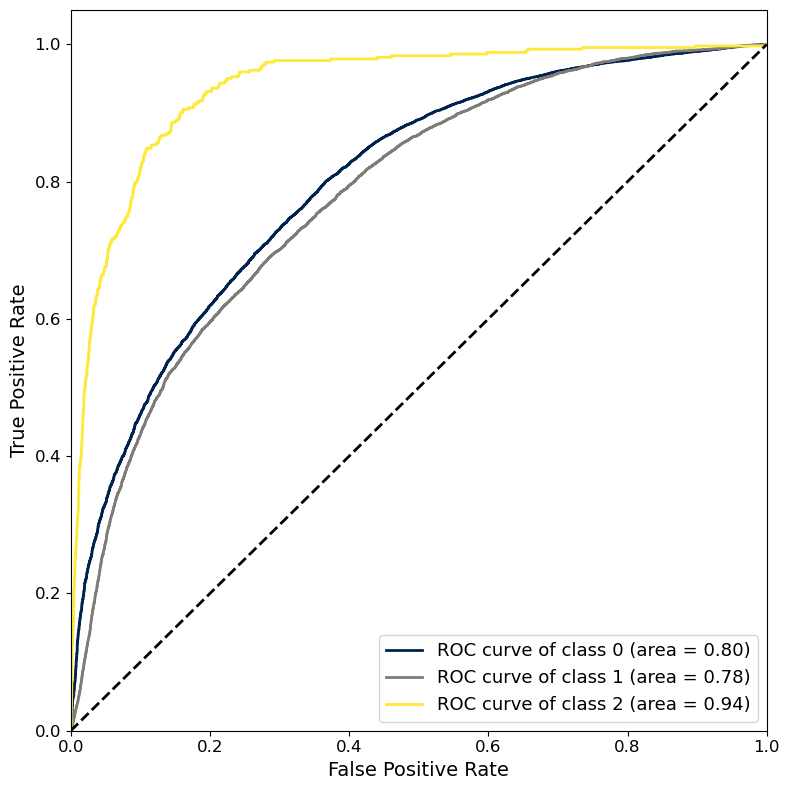

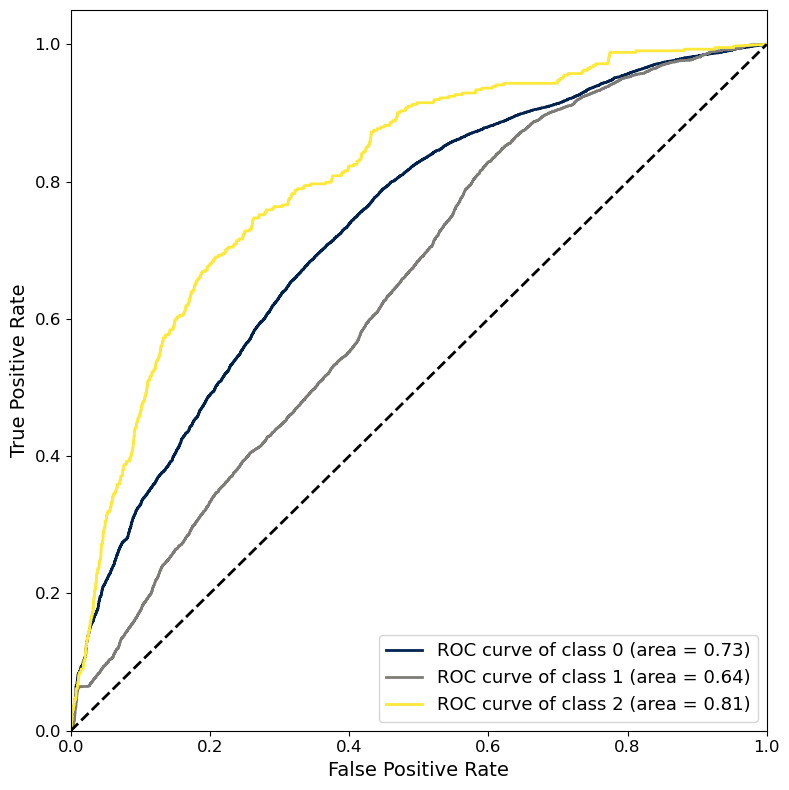

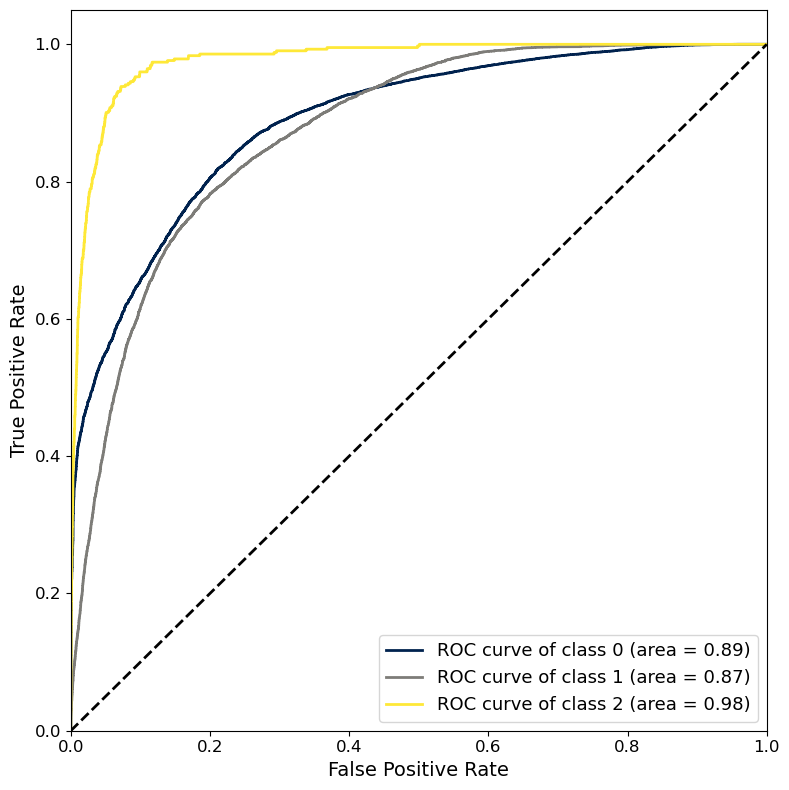

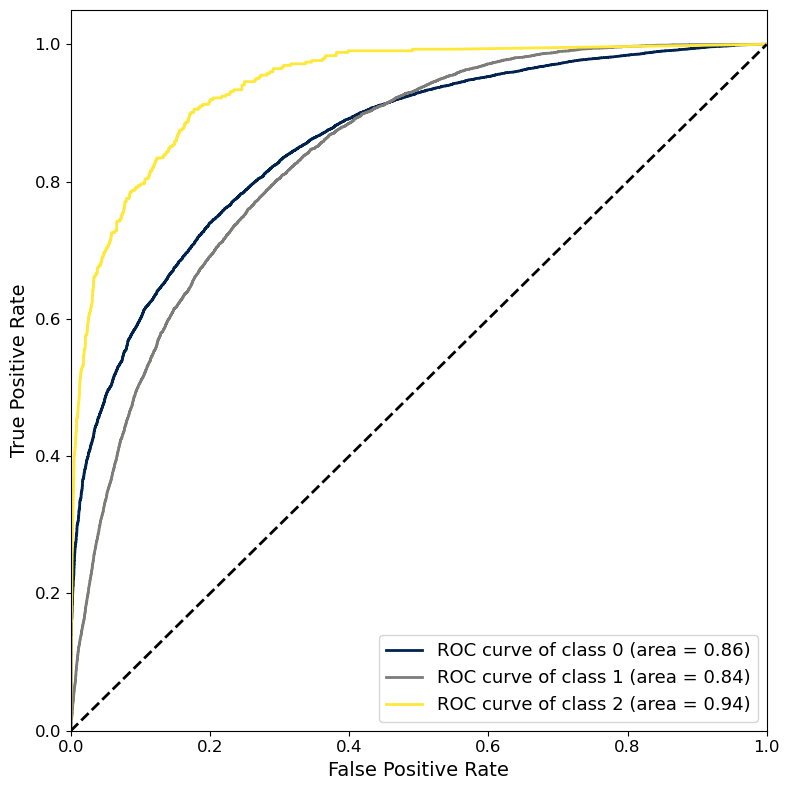

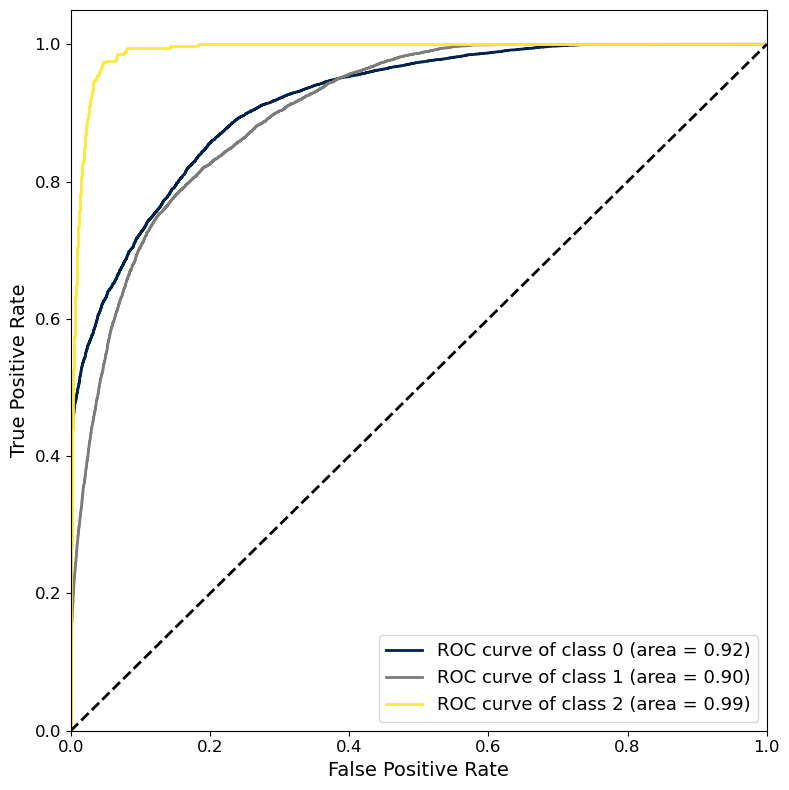

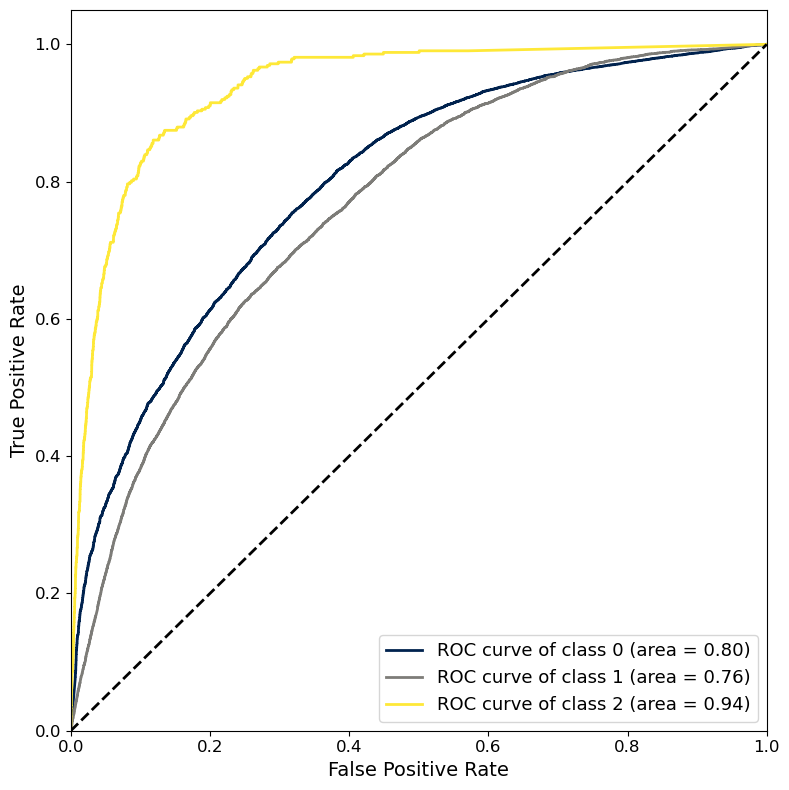

In [42]:
# ROC curves for the linear SVM
plot_roc_curve_multiclass(best_model, X_test, y_test, 'Linear SVM')

# ROC curves for the Naive Bayes
plot_roc_curve_multiclass(pipeline_nb, X_test_nb, y_test_nb, 'Naive Bayes')

# ROC curves for the XGBoost
plot_roc_curve_multiclass(pipeline_xgb, X_test_xgb, y_test_xgb, 'XGBoost')

# ROC curves for the random forest
plot_roc_curve_multiclass(rf_best_model, X_test, y_test, 'Random Forest')

# ROC curves for the neural network
plot_roc_curve_multiclass(mlp_best_model, X_test, y_test, 'Multi-layer Perceptron')

# ROC curves for the SGD classifier
plot_roc_curve_multiclass(sgd_best_model, X_test, y_test, 'SGD Classifier')

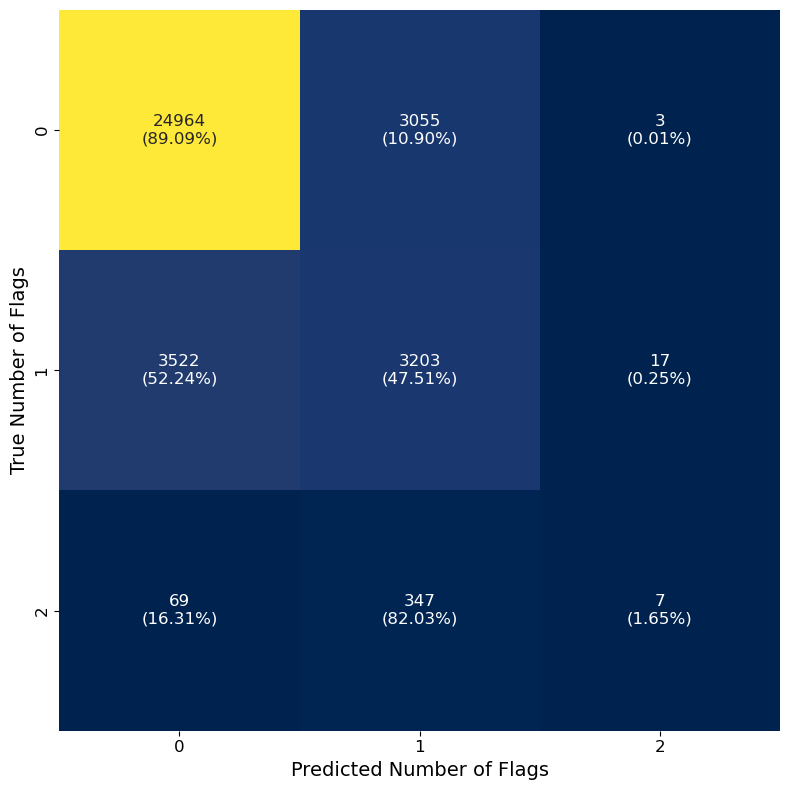

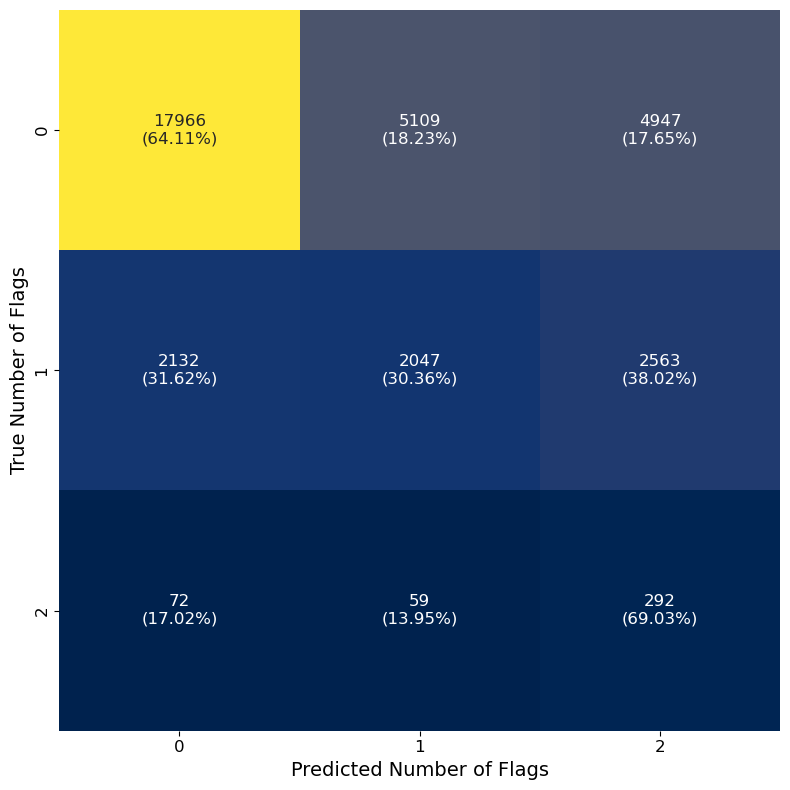

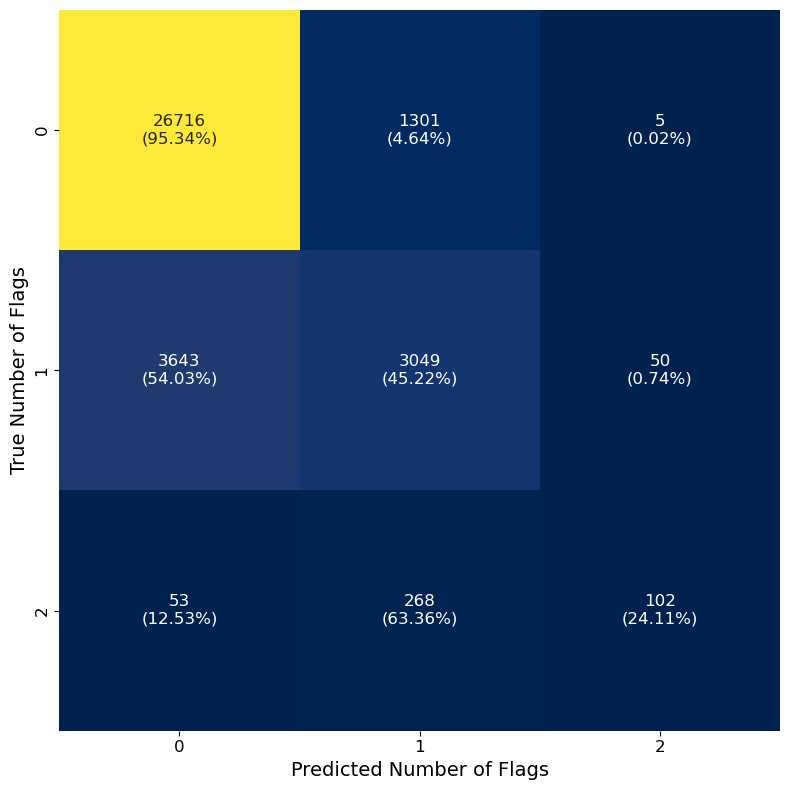

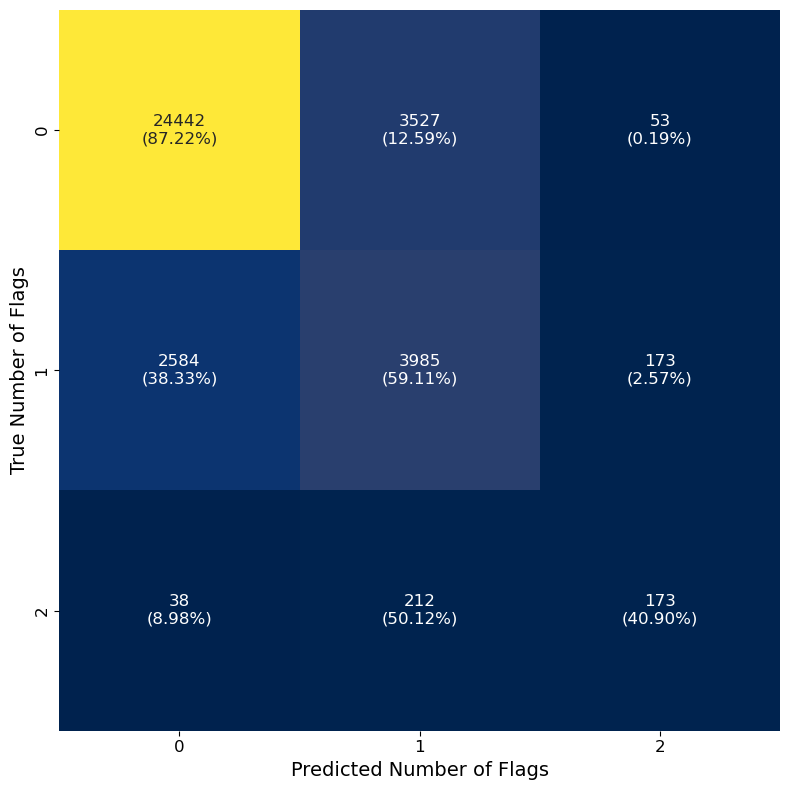

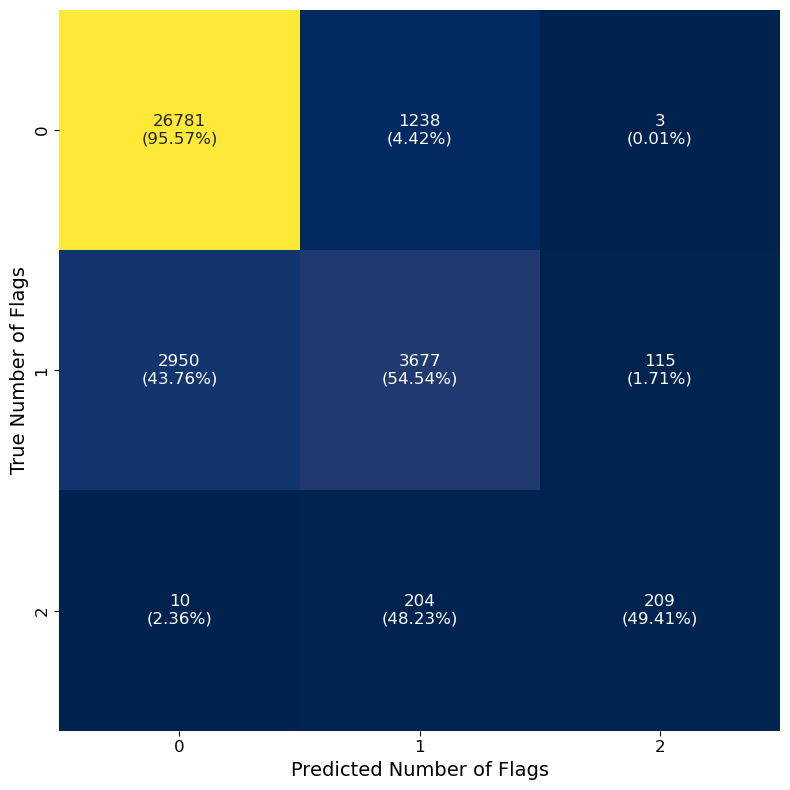

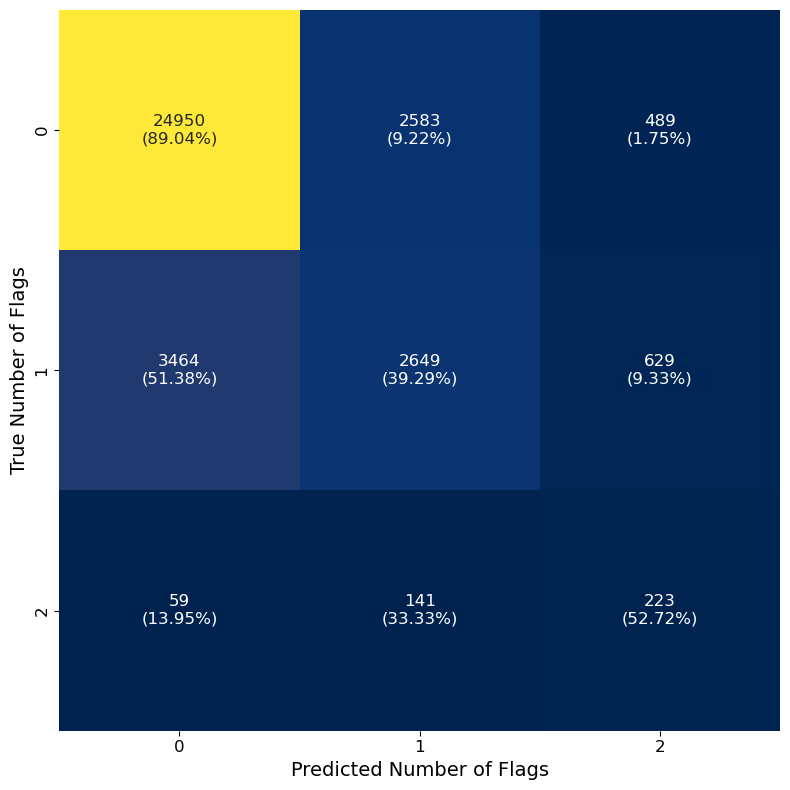

In [37]:
# Plot the confusion matrix for the Linear SVM
plot_confusion_matrix(y_test, y_pred, 'Linear SVM')

# Plot the confusion matrix for the Naive Bayes
plot_confusion_matrix(y_test_nb, y_pred_nb, 'Naive Bayes')

# Plot the confusion matrix for the XGBoost
plot_confusion_matrix(y_test_xgb, y_pred_xgb, 'XGBoost')

# Plot the confusion matrix for the Random Forest
plot_confusion_matrix(y_test, rf_y_pred, 'Random Forest')

# Plot the confusion matrix for the Neural Network
plot_confusion_matrix(y_test, mlp_y_pred, 'Multi-layer Perceptron')

# Plot the confusion matrix for the SGD Classifier
plot_confusion_matrix(y_test, sgd_y_pred, 'SGD Classifier')